In [1]:
import xarray as xr
import numpy as np
from numpy import sqrt
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.special import wofz
import pandas as pd

In [2]:
def voigt_absorption(x, amp, center, sigma, gamma, offset):
    z = ((x - center) + 1j * gamma) / (sigma * np.sqrt(2))
    voigt_prof = np.real(wofz(z)) / (sigma * np.sqrt(2 * np.pi))
    if np.max(np.abs(voigt_prof)) == 0 or np.isnan(np.max(voigt_prof)):
        voigt_norm = np.zeros_like(voigt_prof)
    else:
        voigt_norm = voigt_prof / np.max(voigt_prof)
    return offset - amp * voigt_norm

def polynomial_degree_n(x, n, *coefficients):
    return sum(coefficients[i] * x**i for i in range(n + 1))

def calculate_bic(ssr, N, k):
    if N == 0:
        return np.inf
    return N * np.log(ssr / N) + k * np.log(N)
def build_composite_function(n):
    def composite_function(x, amp, center, sigma, gamma, offset, *coeffs):
        continuum = sum(c * x**i for i, c in enumerate(coeffs))
        return voigt_absorption(x, amp, center, sigma, gamma, offset) + continuum
    return composite_function

In [3]:
def fit_joint_model_with_bic(wavelength, flux, flux_error, lambda_0, w1, w2, max_order=3, min_bic_improvement=10, line_name=None, plot=False):
    mask = (wavelength > w1) & (wavelength < w2)
    x = wavelength[mask]
    y = flux[mask]
    yerr = flux_error[mask] if flux_error is not None else np.ones_like(y)

    best_bic = np.inf
    best_result = None
    no_improve_count = 0

    for n in range(max_order + 1):
        model = build_composite_function(n)

        # === SMART GUESSES BASED ON PREVIOUS VOIGT FITS ===
        offset_region = ((x > w1) & (x < (w1 + 15))) | ((x > (w2 - 15)) & (x < w2))
        # Estimate median from edge regions, but don't clip to 2.0
        offset_guess = np.median(y[offset_region])



        amp_guess = np.clip(offset_guess - np.min(y), 0.1, 10.0)
        center_guess = np.clip(x[np.argmin(y)], w1, w2)
        sigma_guess = 20.0
        gamma_guess = 35.0

        # === SMART BOUNDS BASED ON YOUR PRIOR FITTING EXPERIENCE ===
        lower_bounds = [1e-4, center_guess - 3.0, 0.0, 5.0, offset_guess - 10] + [-np.inf] * (n + 1)
        upper_bounds = [5.0, center_guess + 3.0, 60.0, 60.0, offset_guess + 10] + [np.inf] * (n + 1)

        voigt_guess = [amp_guess, center_guess, sigma_guess, gamma_guess, offset_guess]
        poly_guess = [0.0] * (n + 1)
        poly_guess[0] = offset_guess  # match continuum level

        p0 = voigt_guess + poly_guess

        for i, (val, low, high) in enumerate(zip(p0, lower_bounds, upper_bounds)):
            if not (low <= val <= high):
                print(f"Guess p0[{i}] = {val:.4f} out of bounds ({low:.4f}, {high:.4f})")

        try:
            popt, pcov = curve_fit(
                model, x, y, sigma=yerr,
                p0=p0, bounds=(lower_bounds, upper_bounds),
                maxfev=50000, absolute_sigma=True
            )
            # Print parameter breakdown
            amp, center, sigma, gamma, offset = popt[:5]
            print(f"[Order {n}] Voigt params:")
            print(f"  Amp = {amp:.3f}, Center = {center:.3f}, Sigma = {sigma:.3f}, Gamma = {gamma:.3f}, Offset = {offset:.3f}")

        except RuntimeError as e:
            print(f"Order {n} fit failed: {e}")
            no_improve_count += 1
            if no_improve_count >= 2:
                print("Early stopping due to consecutive failures.")
                break
            continue

        residuals = y - model(x, *popt)
        ssr = np.sum((residuals / yerr) ** 2)
        N = len(y)
        k = len(popt)
        bic = N * np.log(ssr / N) + k * np.log(N)

        print(f"Order {n}: BIC = {bic:.2f}")

        if bic < best_bic - min_bic_improvement:
            best_bic = bic
            best_result = (popt, pcov, n)
            no_improve_count = 0
        else:
            no_improve_count += 1
            if no_improve_count >= 2:
                print(f"Stopping early at order {n} due to no BIC improvement.")
                break

    if best_result is None:
        print("All fits failed.")
        return np.nan, np.nan, np.nan, np.nan

    popt, pcov, best_order = best_result
    amp, center, sigma, gamma, offset = popt[:5]
    center_err = np.sqrt(np.diag(pcov))[1]

    c_kms = 299792.458
    velocity = c_kms * (center - lambda_0) / lambda_0
    velocity_err = c_kms * center_err / lambda_0

    print(f"Order {n}: BIC = {bic:.2f}, SSR = {ssr:.2f}, k = {k}")

    if plot:
        import matplotlib.pyplot as plt
        plt.figure(figsize=(7, 4))
        plt.errorbar(x, y, yerr=yerr, fmt='.', label='Data')
        plt.plot(x, build_composite_function(best_order)(x, *popt), label=f'Fit (order {best_order})')
        plt.xlabel("Wavelength")
        plt.ylabel("Flux")
        plt.title(f"{line_name or 'Line'} fit")
        plt.legend()
        plt.tight_layout()
        plt.show()

    return center, center_err, velocity, velocity_err


[Order 0] Voigt params:
  Amp = 0.943, Center = 4865.710, Sigma = 0.000, Gamma = 16.679, Offset = 1.717
Order 0: BIC = 19.68
[Order 1] Voigt params:
  Amp = 0.876, Center = 4865.119, Sigma = 0.000, Gamma = 14.039, Offset = 2.276
Order 1: BIC = 14.71
[Order 2] Voigt params:
  Amp = 0.734, Center = 4865.554, Sigma = 0.000, Gamma = 9.804, Offset = 1.627
Order 2: BIC = -9.81
[Order 3] Voigt params:
  Amp = 0.727, Center = 4865.537, Sigma = 0.000, Gamma = 9.643, Offset = -8.439
Order 3: BIC = -5.64
[Order 4] Voigt params:
  Amp = 0.988, Center = 4865.669, Sigma = 19.590, Gamma = 34.830, Offset = 1.561
Order 4: BIC = 175.02
Stopping early at order 4 due to no BIC improvement.
Order 4: BIC = 175.02, SSR = 363.89, k = 10


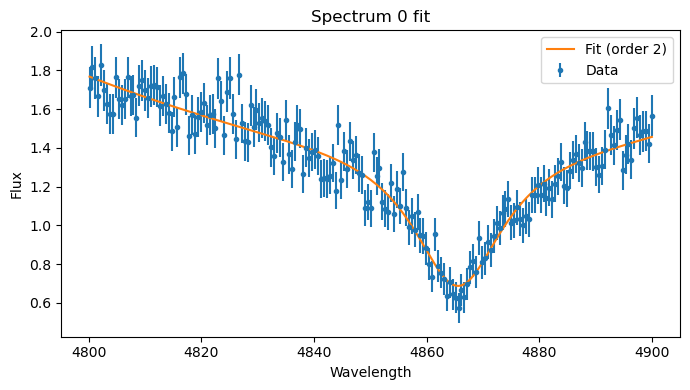

[Order 0] Voigt params:
  Amp = 0.944, Center = 4865.798, Sigma = 0.000, Gamma = 15.880, Offset = 1.593
Order 0: BIC = 45.20
[Order 1] Voigt params:
  Amp = 0.878, Center = 4865.254, Sigma = 0.001, Gamma = 13.422, Offset = 2.688
Order 1: BIC = 38.04
[Order 2] Voigt params:
  Amp = 0.759, Center = 4865.700, Sigma = 0.005, Gamma = 10.083, Offset = 1.595
Order 2: BIC = 19.56
[Order 3] Voigt params:
  Amp = 0.754, Center = 4865.692, Sigma = 0.000, Gamma = 9.971, Offset = -5.018
Order 3: BIC = 24.10
[Order 4] Voigt params:
  Amp = 0.988, Center = 4866.185, Sigma = 19.566, Gamma = 34.820, Offset = 1.594
Order 4: BIC = 220.67
Stopping early at order 4 due to no BIC improvement.
Order 4: BIC = 220.67, SSR = 460.99, k = 10


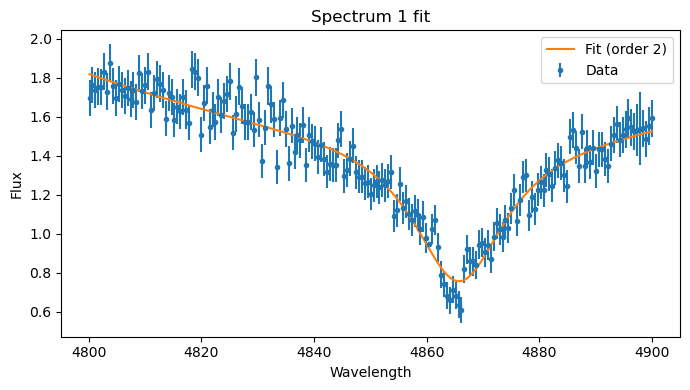

[Order 0] Voigt params:
  Amp = 0.925, Center = 4866.300, Sigma = 0.000, Gamma = 19.851, Offset = 1.471
Order 0: BIC = 65.45
[Order 1] Voigt params:
  Amp = 0.805, Center = 4865.190, Sigma = 0.000, Gamma = 14.682, Offset = 2.553
Order 1: BIC = 53.23
[Order 2] Voigt params:
  Amp = 0.648, Center = 4865.663, Sigma = 0.003, Gamma = 9.062, Offset = 1.467
Order 2: BIC = 21.99
[Order 3] Voigt params:
  Amp = 0.641, Center = 4865.645, Sigma = 0.000, Gamma = 8.883, Offset = -8.535
Order 3: BIC = 25.74
[Order 4] Voigt params:
  Amp = 0.968, Center = 4867.779, Sigma = 5.883, Gamma = 21.096, Offset = 1.578
Order 4: BIC = 99.94
Stopping early at order 4 due to no BIC improvement.
Order 4: BIC = 99.94, SSR = 246.61, k = 10


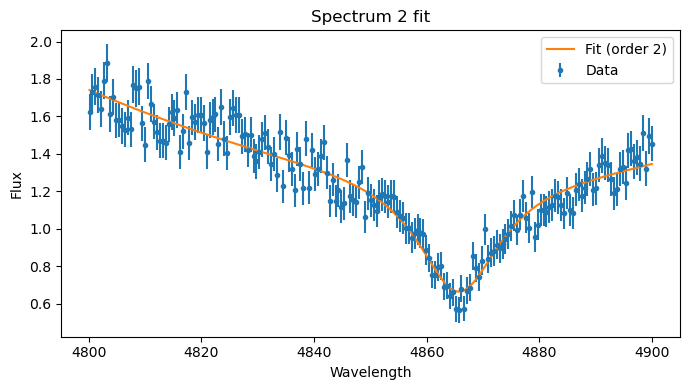

[Order 0] Voigt params:
  Amp = 0.932, Center = 4865.462, Sigma = 0.000, Gamma = 14.506, Offset = 1.588
Order 0: BIC = 77.51
[Order 1] Voigt params:
  Amp = 0.865, Center = 4864.864, Sigma = 0.000, Gamma = 11.806, Offset = 1.593
Order 1: BIC = 61.39
[Order 2] Voigt params:
  Amp = 0.753, Center = 4865.294, Sigma = 0.000, Gamma = 8.812, Offset = 1.372
Order 2: BIC = 32.99
[Order 3] Voigt params:
  Amp = 0.749, Center = 4865.288, Sigma = 0.001, Gamma = 8.746, Offset = 1.409
Order 3: BIC = 37.78
[Order 4] Voigt params:
  Amp = 1.021, Center = 4864.117, Sigma = 19.559, Gamma = 34.817, Offset = 1.588
Order 4: BIC = 262.06
Stopping early at order 4 due to no BIC improvement.
Order 4: BIC = 262.06, SSR = 571.25, k = 10


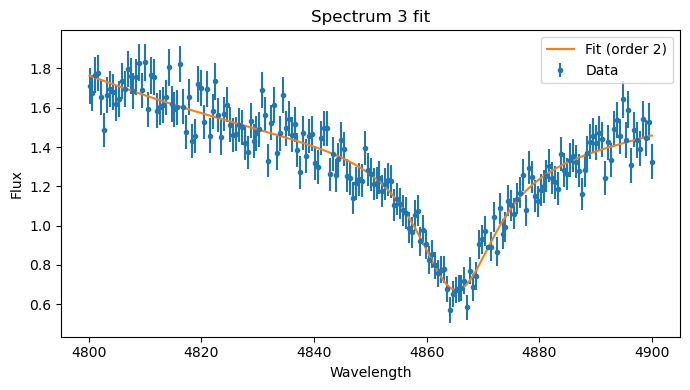

[Order 0] Voigt params:
  Amp = 0.902, Center = 4865.416, Sigma = 0.000, Gamma = 17.342, Offset = 1.428
Order 0: BIC = 71.54
[Order 1] Voigt params:
  Amp = 0.829, Center = 4864.719, Sigma = 0.000, Gamma = 14.309, Offset = 1.437
Order 1: BIC = 65.81
[Order 2] Voigt params:
  Amp = 0.683, Center = 4865.160, Sigma = 0.000, Gamma = 9.523, Offset = 2.570
Order 2: BIC = 44.17
[Order 3] Voigt params:
  Amp = 0.678, Center = 4865.147, Sigma = 0.000, Gamma = 9.384, Offset = -8.567
Order 3: BIC = 48.69
[Order 4] Voigt params:
  Amp = 0.966, Center = 4864.638, Sigma = 19.527, Gamma = 34.802, Offset = 1.432
Order 4: BIC = 212.95
Stopping early at order 4 due to no BIC improvement.
Order 4: BIC = 212.95, SSR = 442.92, k = 10


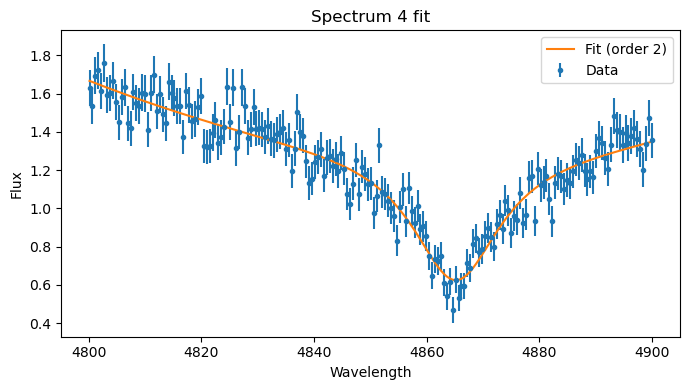

[Order 0] Voigt params:
  Amp = 0.971, Center = 4864.873, Sigma = 0.000, Gamma = 15.543, Offset = 1.614
Order 0: BIC = 99.92
[Order 1] Voigt params:
  Amp = 0.886, Center = 4864.048, Sigma = 0.000, Gamma = 12.031, Offset = 1.634
Order 1: BIC = 74.77
[Order 2] Voigt params:
  Amp = 0.767, Center = 4864.410, Sigma = 0.000, Gamma = 8.943, Offset = 1.639
Order 2: BIC = 49.70
[Order 3] Voigt params:
  Amp = 0.756, Center = 4864.385, Sigma = 0.001, Gamma = 8.724, Offset = -8.163
Order 3: BIC = 52.86
[Order 4] Voigt params:
  Amp = 1.024, Center = 4863.593, Sigma = 19.523, Gamma = 34.797, Offset = 1.632
Order 4: BIC = 271.76
Stopping early at order 4 due to no BIC improvement.
Order 4: BIC = 271.76, SSR = 600.69, k = 10


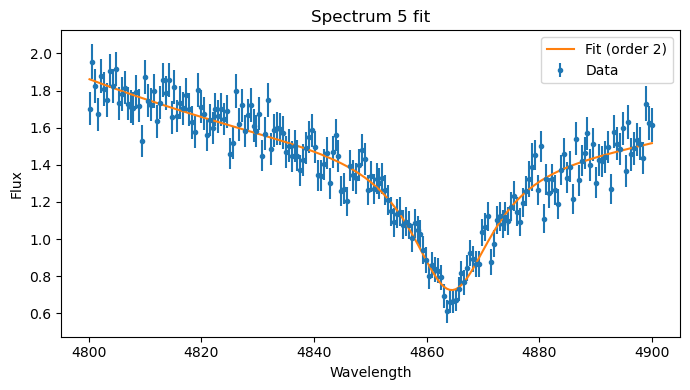

[Order 0] Voigt params:
  Amp = 0.899, Center = 4865.139, Sigma = 0.002, Gamma = 18.952, Offset = 1.462
Order 0: BIC = 47.13
[Order 1] Voigt params:
  Amp = 0.829, Center = 4864.425, Sigma = 0.000, Gamma = 16.246, Offset = 1.463
Order 1: BIC = 43.57
[Order 2] Voigt params:
  Amp = 0.682, Center = 4864.853, Sigma = 0.000, Gamma = 11.732, Offset = 2.994
Order 2: BIC = 31.79
[Order 3] Voigt params:
  Amp = 0.668, Center = 4864.825, Sigma = 0.000, Gamma = 11.368, Offset = -8.537
Order 3: BIC = 35.24
[Order 4] Voigt params:
  Amp = 0.924, Center = 4864.622, Sigma = 19.605, Gamma = 34.829, Offset = 1.463
Order 4: BIC = 187.17
Stopping early at order 4 due to no BIC improvement.
Order 4: BIC = 187.17, SSR = 387.54, k = 10


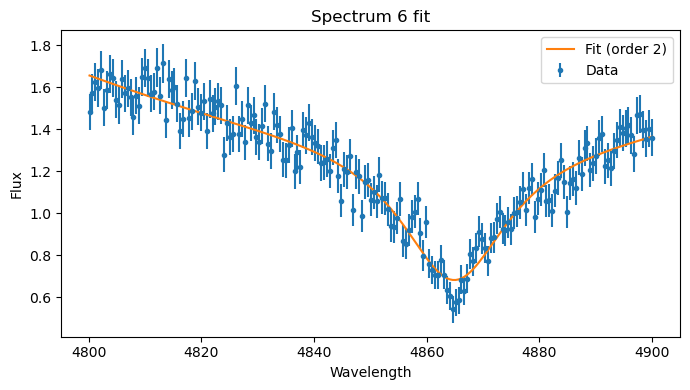

[Order 0] Voigt params:
  Amp = 1.053, Center = 4864.561, Sigma = 0.000, Gamma = 14.777, Offset = 2.011
Order 0: BIC = 19.87
[Order 1] Voigt params:
  Amp = 1.021, Center = 4864.262, Sigma = 0.000, Gamma = 13.710, Offset = 1.809
Order 1: BIC = 23.84
[Order 2] Voigt params:
  Amp = 0.899, Center = 4864.492, Sigma = 0.000, Gamma = 11.074, Offset = 1.543
Order 2: BIC = 22.84
Stopping early at order 2 due to no BIC improvement.
Order 2: BIC = 22.84, SSR = 174.67, k = 8


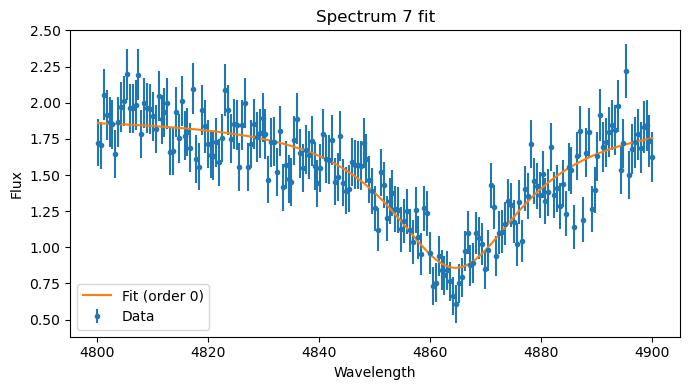

[Order 0] Voigt params:
  Amp = 1.030, Center = 4864.843, Sigma = 0.002, Gamma = 18.699, Offset = 1.667
Order 0: BIC = -19.86
[Order 1] Voigt params:
  Amp = 0.931, Center = 4863.882, Sigma = 0.002, Gamma = 15.295, Offset = 1.668
Order 1: BIC = -22.76
[Order 2] Voigt params:
  Amp = 0.769, Center = 4864.331, Sigma = 0.000, Gamma = 11.276, Offset = 1.531
Order 2: BIC = -26.73
[Order 3] Voigt params:
  Amp = 1.037, Center = 4865.000, Sigma = 0.007, Gamma = 15.686, Offset = 1.675
Order 3: BIC = -22.59
[Order 4] Voigt params:
  Amp = 1.102, Center = 4863.600, Sigma = 19.444, Gamma = 34.758, Offset = 1.667
Order 4: BIC = 75.77
Stopping early at order 4 due to no BIC improvement.
Order 4: BIC = 75.77, SSR = 217.58, k = 10


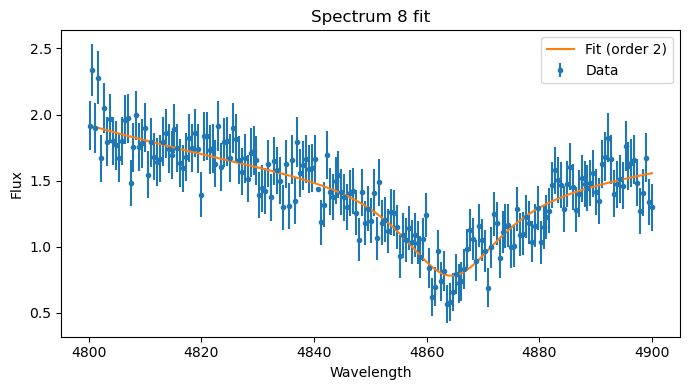

[Order 0] Voigt params:
  Amp = 0.968, Center = 4864.320, Sigma = 0.000, Gamma = 16.058, Offset = 1.716
Order 0: BIC = 105.52
[Order 1] Voigt params:
  Amp = 0.887, Center = 4863.532, Sigma = 0.000, Gamma = 12.492, Offset = 1.695
Order 1: BIC = 87.56
[Order 2] Voigt params:
  Amp = 0.727, Center = 4863.849, Sigma = 0.000, Gamma = 7.836, Offset = 1.706
Order 2: BIC = 32.90
[Order 3] Voigt params:
  Amp = 0.721, Center = 4863.830, Sigma = 0.000, Gamma = 7.706, Offset = -8.290
Order 3: BIC = 36.48
[Order 4] Voigt params:
  Amp = 1.043, Center = 4863.594, Sigma = 19.592, Gamma = 34.826, Offset = 1.710
Order 4: BIC = 267.58
Stopping early at order 4 due to no BIC improvement.
Order 4: BIC = 267.58, SSR = 587.83, k = 10


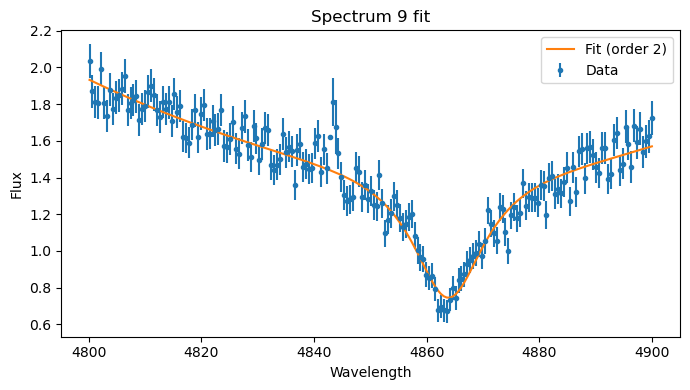

[Order 0] Voigt params:
  Amp = 0.906, Center = 4864.590, Sigma = 0.000, Gamma = 19.181, Offset = 1.483
Order 0: BIC = 48.37
[Order 1] Voigt params:
  Amp = 0.815, Center = 4863.582, Sigma = 0.000, Gamma = 15.457, Offset = 1.563
Order 1: BIC = 33.74
[Order 2] Voigt params:
  Amp = 0.667, Center = 4863.986, Sigma = 0.000, Gamma = 11.000, Offset = 2.283
Order 2: BIC = 14.57
[Order 3] Voigt params:
  Amp = 0.643, Center = 4863.916, Sigma = 0.000, Gamma = 10.402, Offset = -8.183
Order 3: BIC = 16.41
[Order 4] Voigt params:
  Amp = 0.890, Center = 4864.617, Sigma = 19.546, Gamma = 34.802, Offset = 1.466
Order 4: BIC = 202.82
Stopping early at order 4 due to no BIC improvement.
Order 4: BIC = 202.82, SSR = 420.26, k = 10


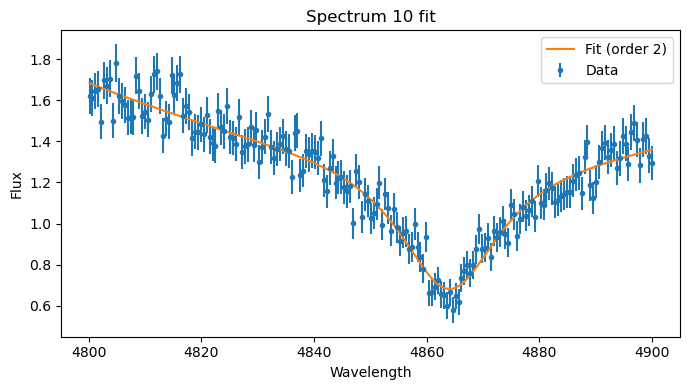

[Order 0] Voigt params:
  Amp = 0.986, Center = 4863.808, Sigma = 0.002, Gamma = 15.208, Offset = 1.694
Order 0: BIC = 53.99
[Order 1] Voigt params:
  Amp = 0.956, Center = 4863.529, Sigma = 0.000, Gamma = 14.160, Offset = 1.692
Order 1: BIC = 55.25
[Order 2] Voigt params:
  Amp = 0.808, Center = 4863.854, Sigma = 0.000, Gamma = 10.501, Offset = 1.718
Order 2: BIC = 32.26
[Order 3] Voigt params:
  Amp = 0.799, Center = 4863.833, Sigma = 0.000, Gamma = 10.322, Offset = -8.307
Order 3: BIC = 36.09
[Order 4] Voigt params:
  Amp = 1.050, Center = 4863.068, Sigma = 19.528, Gamma = 34.796, Offset = 1.693
Order 4: BIC = 265.00
Stopping early at order 4 due to no BIC improvement.
Order 4: BIC = 265.00, SSR = 580.01, k = 10


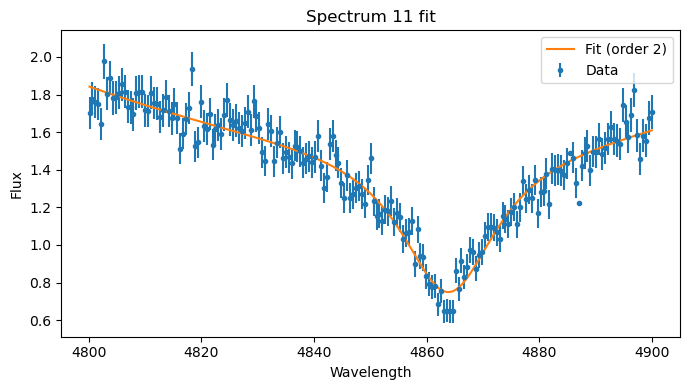

[Order 0] Voigt params:
  Amp = 0.879, Center = 4863.957, Sigma = 0.000, Gamma = 16.091, Offset = 1.477
Order 0: BIC = 45.14
[Order 1] Voigt params:
  Amp = 0.847, Center = 4863.654, Sigma = 0.000, Gamma = 14.791, Offset = 1.468
Order 1: BIC = 46.47
[Order 2] Voigt params:
  Amp = 0.657, Center = 4864.243, Sigma = 0.000, Gamma = 9.234, Offset = 1.479
Order 2: BIC = -24.63
[Order 3] Voigt params:
  Amp = 0.652, Center = 4864.227, Sigma = 0.001, Gamma = 9.133, Offset = -7.813
Order 3: BIC = -20.25
[Order 4] Voigt params:
  Amp = 0.924, Center = 4864.630, Sigma = 19.553, Gamma = 34.811, Offset = 1.475
Order 4: BIC = 223.62
Stopping early at order 4 due to no BIC improvement.
Order 4: BIC = 223.62, SSR = 468.09, k = 10


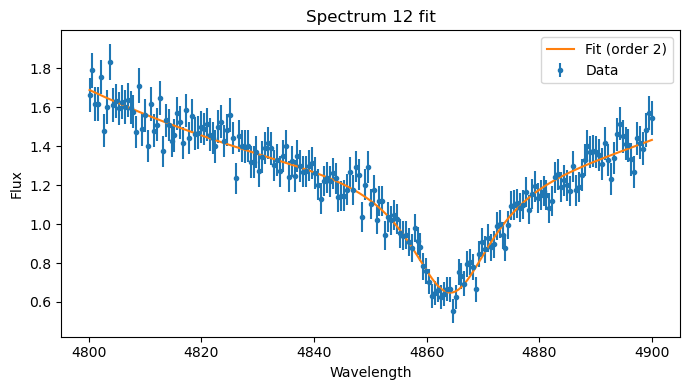

[Order 0] Voigt params:
  Amp = 0.989, Center = 4864.091, Sigma = 0.000, Gamma = 16.515, Offset = 1.735
Order 0: BIC = 52.04
[Order 1] Voigt params:
  Amp = 0.918, Center = 4863.403, Sigma = 0.000, Gamma = 13.895, Offset = 1.697
Order 1: BIC = 36.36
[Order 2] Voigt params:
  Amp = 0.789, Center = 4863.725, Sigma = 0.004, Gamma = 10.545, Offset = 1.697
Order 2: BIC = 17.71
[Order 3] Voigt params:
  Amp = 0.783, Center = 4863.713, Sigma = 0.000, Gamma = 10.423, Offset = -8.306
Order 3: BIC = 21.87
[Order 4] Voigt params:
  Amp = 1.058, Center = 4862.540, Sigma = 19.514, Gamma = 34.785, Offset = 1.694
Order 4: BIC = 252.21
Stopping early at order 4 due to no BIC improvement.
Order 4: BIC = 252.21, SSR = 542.83, k = 10


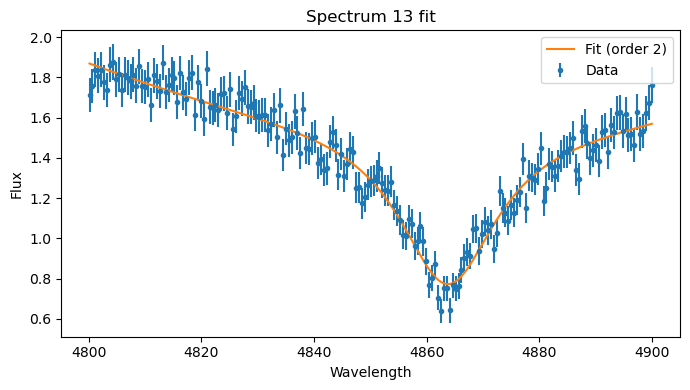

[Order 0] Voigt params:
  Amp = 0.903, Center = 4863.653, Sigma = 0.000, Gamma = 16.260, Offset = 1.484
Order 0: BIC = 61.46
[Order 1] Voigt params:
  Amp = 0.824, Center = 4862.709, Sigma = 0.000, Gamma = 12.699, Offset = 1.324
Order 1: BIC = 27.35
[Order 2] Voigt params:
  Amp = 0.722, Center = 4863.015, Sigma = 0.000, Gamma = 9.727, Offset = 2.452
Order 2: BIC = 13.20
[Order 3] Voigt params:
  Amp = 0.712, Center = 4862.991, Sigma = 0.001, Gamma = 9.492, Offset = -5.486
Order 3: BIC = 16.30
[Order 4] Voigt params:
  Amp = 0.907, Center = 4862.525, Sigma = 19.373, Gamma = 34.714, Offset = 1.482
Order 4: BIC = 249.23
Stopping early at order 4 due to no BIC improvement.
Order 4: BIC = 249.23, SSR = 534.52, k = 10


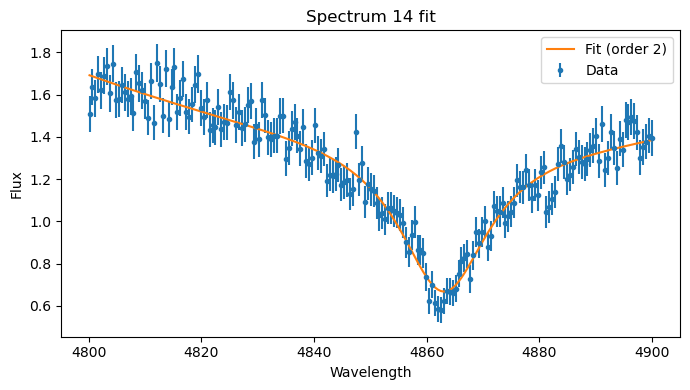

[Order 0] Voigt params:
  Amp = 0.993, Center = 4864.345, Sigma = 0.000, Gamma = 14.613, Offset = 1.708
Order 0: BIC = 77.46
[Order 1] Voigt params:
  Amp = 0.942, Center = 4863.883, Sigma = 0.000, Gamma = 12.721, Offset = 1.713
Order 1: BIC = 70.63
[Order 2] Voigt params:
  Amp = 0.816, Center = 4864.156, Sigma = 0.000, Gamma = 9.455, Offset = 1.712
Order 2: BIC = 48.09
[Order 3] Voigt params:
  Amp = 0.808, Center = 4864.136, Sigma = 0.000, Gamma = 9.293, Offset = -8.292
Order 3: BIC = 51.85
[Order 4] Voigt params:
  Amp = 1.066, Center = 4863.069, Sigma = 19.495, Gamma = 34.782, Offset = 1.708
Order 4: BIC = 283.80
Stopping early at order 4 due to no BIC improvement.
Order 4: BIC = 283.80, SSR = 639.38, k = 10


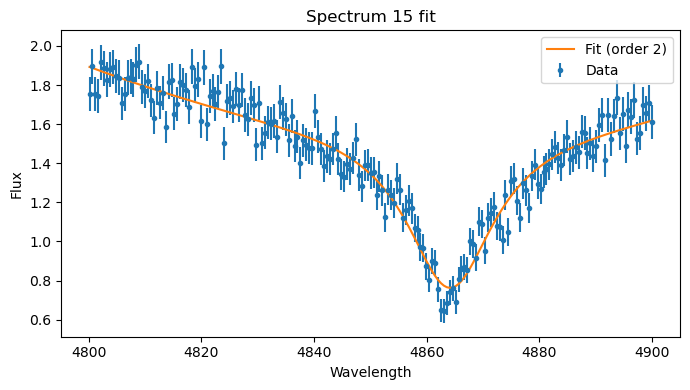

[Order 0] Voigt params:
  Amp = 0.948, Center = 4864.112, Sigma = 0.000, Gamma = 17.146, Offset = 0.776
Order 0: BIC = 72.63
[Order 1] Voigt params:
  Amp = 0.865, Center = 4863.252, Sigma = 0.000, Gamma = 13.749, Offset = 1.559
Order 1: BIC = 54.13
[Order 2] Voigt params:
  Amp = 0.727, Center = 4863.639, Sigma = 0.002, Gamma = 9.711, Offset = 1.565
Order 2: BIC = 33.54
[Order 3] Voigt params:
  Amp = 0.720, Center = 4863.624, Sigma = 0.000, Gamma = 9.539, Offset = -8.443
Order 3: BIC = 37.33
[Order 4] Voigt params:
  Amp = 0.962, Center = 4862.539, Sigma = 19.491, Gamma = 34.774, Offset = 1.557
Order 4: BIC = 238.32
Stopping early at order 4 due to no BIC improvement.
Order 4: BIC = 238.32, SSR = 505.13, k = 10


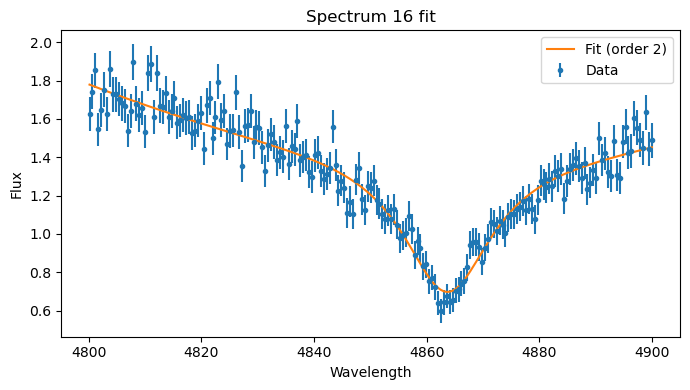

[Order 0] Voigt params:
  Amp = 1.096, Center = 4864.545, Sigma = 0.000, Gamma = 15.359, Offset = 1.852
Order 0: BIC = 49.76
[Order 1] Voigt params:
  Amp = 1.035, Center = 4864.052, Sigma = 0.000, Gamma = 13.351, Offset = 1.844
Order 1: BIC = 39.98
[Order 2] Voigt params:
  Amp = 0.879, Center = 4864.424, Sigma = 0.000, Gamma = 9.811, Offset = 1.842
Order 2: BIC = 2.67
[Order 3] Voigt params:
  Amp = 0.873, Center = 4864.414, Sigma = 0.000, Gamma = 9.715, Offset = -6.459
Order 3: BIC = 6.76
[Order 4] Voigt params:
  Amp = 1.196, Center = 4864.625, Sigma = 19.526, Gamma = 34.798, Offset = 1.845
Order 4: BIC = 273.45
Stopping early at order 4 due to no BIC improvement.
Order 4: BIC = 273.45, SSR = 605.97, k = 10


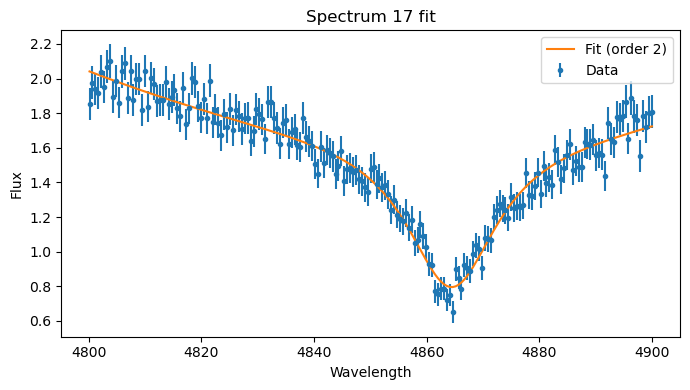

[Order 0] Voigt params:
  Amp = 0.990, Center = 4864.507, Sigma = 0.000, Gamma = 16.418, Offset = 1.627
Order 0: BIC = 18.10
[Order 1] Voigt params:
  Amp = 0.920, Center = 4863.804, Sigma = 0.000, Gamma = 14.010, Offset = 1.633
Order 1: BIC = 2.44
[Order 2] Voigt params:
  Amp = 0.833, Center = 4864.076, Sigma = 0.000, Gamma = 12.005, Offset = 1.332
Order 2: BIC = -1.38
[Order 3] Voigt params:
  Amp = 0.824, Center = 4864.061, Sigma = 0.000, Gamma = 11.847, Offset = -8.367
Order 3: BIC = 3.09
[Order 4] Voigt params:
  Amp = 1.026, Center = 4864.098, Sigma = 19.461, Gamma = 34.765, Offset = 1.633
Order 4: BIC = 222.72
Stopping early at order 4 due to no BIC improvement.
Order 4: BIC = 222.72, SSR = 465.92, k = 10


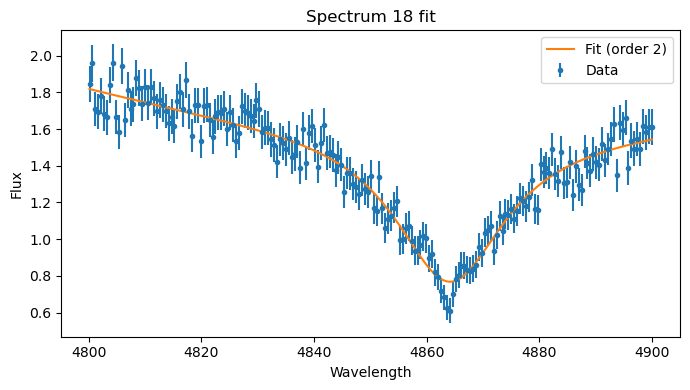

[Order 0] Voigt params:
  Amp = 1.057, Center = 4865.177, Sigma = 0.000, Gamma = 15.240, Offset = 1.810
Order 0: BIC = 57.86
[Order 1] Voigt params:
  Amp = 1.005, Center = 4864.779, Sigma = 0.002, Gamma = 13.550, Offset = 1.816
Order 1: BIC = 53.61
[Order 2] Voigt params:
  Amp = 0.839, Center = 4865.251, Sigma = 0.000, Gamma = 9.769, Offset = 1.869
Order 2: BIC = 6.68
[Order 3] Voigt params:
  Amp = 0.832, Center = 4865.235, Sigma = 0.000, Gamma = 9.653, Offset = -8.189
Order 3: BIC = 11.13
[Order 4] Voigt params:
  Amp = 1.118, Center = 4863.609, Sigma = 19.594, Gamma = 34.827, Offset = 1.810
Order 4: BIC = 270.88
Stopping early at order 4 due to no BIC improvement.
Order 4: BIC = 270.88, SSR = 597.98, k = 10


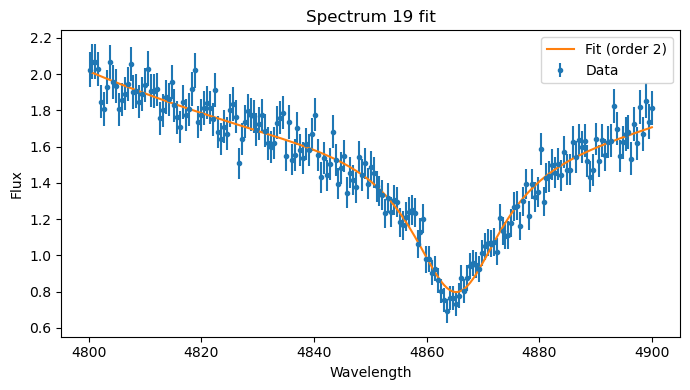

[Order 0] Voigt params:
  Amp = 1.064, Center = 4865.034, Sigma = 0.000, Gamma = 16.124, Offset = 1.753
Order 0: BIC = 36.88
[Order 1] Voigt params:
  Amp = 1.006, Center = 4864.525, Sigma = 0.000, Gamma = 14.227, Offset = 1.753
Order 1: BIC = 33.24
[Order 2] Voigt params:
  Amp = 0.872, Center = 4864.771, Sigma = 0.001, Gamma = 11.128, Offset = 1.776
Order 2: BIC = 19.46
[Order 3] Voigt params:
  Amp = 0.860, Center = 4864.742, Sigma = 0.001, Gamma = 10.902, Offset = -7.473
Order 3: BIC = 23.23
[Order 4] Voigt params:
  Amp = 1.036, Center = 4864.632, Sigma = 19.533, Gamma = 34.800, Offset = 1.738
Order 4: BIC = 234.74
Stopping early at order 4 due to no BIC improvement.
Order 4: BIC = 234.74, SSR = 495.86, k = 10


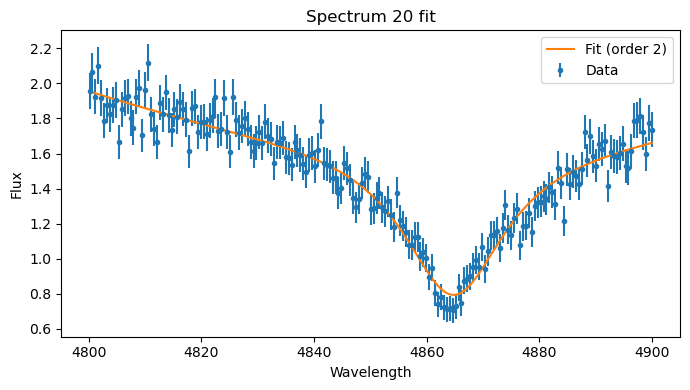

<xarray.Dataset> Size: 840B
Dimensions:                (time: 21)
Coordinates:
  * time                   (time) datetime64[ns] 168B 2025-02-25T10:54:14 ......
Data variables:
    radial_velocity        (time) float64 168B 280.8 289.8 287.6 ... 262.2 232.6
    radial_velocity_error  (time) float64 168B 20.79 18.61 19.86 ... 15.6 17.97
    center                 (time) float64 168B 4.866e+03 4.866e+03 ... 4.865e+03
    center_error           (time) float64 168B 0.337 0.3017 ... 0.253 0.2915


In [48]:
ds = xr.open_dataset("WD1202/WD1202_spectra.nc")
wavelength = ds['wavelength'].values
flux_array = ds['flux_calibrated'].values
flux_error_array = ds['flux_calibrated_error'].values

wavelength_shifted = wavelength

num_spectra = flux_array.shape[0]

centers = []
center_errs = []
velocities = []
velocity_errs = []

for i in range(num_spectra):
    flux = flux_array[i, :]
    flux_err = flux_error_array[i, :]
    # --- SCALE DATA TO ORDER UNITY ---
    scale = np.nanmedian(np.abs(flux))
    if not np.isfinite(scale) or scale == 0:
        scale = 1.0

    flux = flux / scale
    flux_err = flux_err / scale
    
    center, center_err, velocity, velocity_err = fit_joint_model_with_bic(
        wavelength_shifted,
        flux,
        flux_error=flux_err,
        lambda_0=4861,  # or whichever line you're fitting
        w1=4800,
        w2=4900,
        line_name=f"Spectrum {i}",
        max_order=5,
        min_bic_improvement=0,
        plot=(i % 1 == 0)  # plot every 25th spectrum for diagnostics
    )

    centers.append(center)
    center_errs.append(center_err)
    velocities.append(velocity)
    velocity_errs.append(velocity_err)

# Convert to xarrays
vel_da = xr.DataArray(
    data=velocities,
    coords={"time": ds.time},
    dims=["time"],
    name="radial_velocity",
    attrs={"units": "km/s", "description": "Radial velocity from Hα centroid"}
)

center_da = xr.DataArray(
    data=centers,
    coords={"time": ds.time},
    dims=["time"],
    name="center",
    attrs={"units": "Angstrom", "description": "Fitted centroid of Hα absorption"}
)

centroid_err_da = xr.DataArray(
    data=center_errs,
    coords={"time": ds.time},
    dims=["time"],
    name="center_error",
    attrs={"units": "Angstrom", "description": "Uncertainty in fitted Hα centroid"}
)

vel_err_da = xr.DataArray(
    data=velocity_errs,
    coords={"time": ds.time},
    dims=["time"],
    name="radial_velocity_error",
    attrs={"units": "km/s", "description": "Uncertainty in radial velocity from Hα centroid"}
)

fit_results_ds = xr.Dataset({
    "radial_velocity": vel_da,
    "radial_velocity_error": vel_err_da,
    "center": center_da,
    "center_error": centroid_err_da
})
print(fit_results_ds)



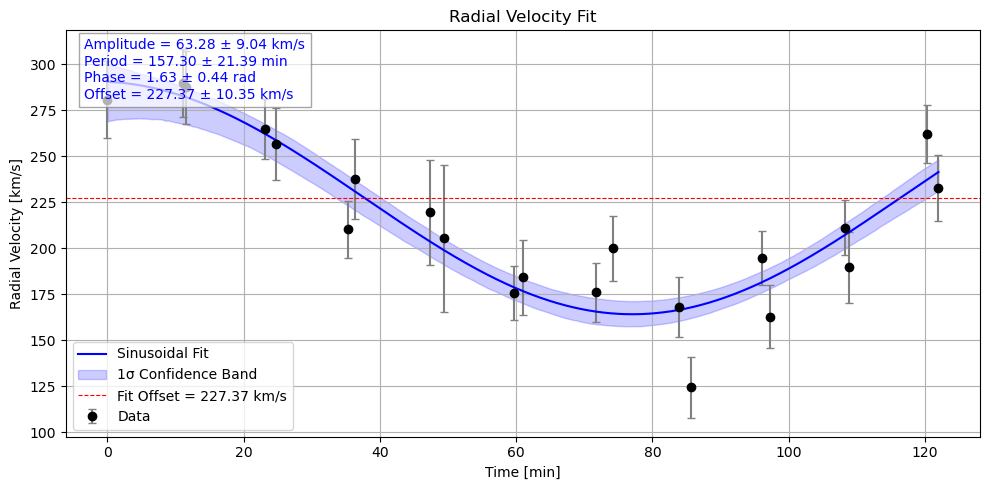

Amplitude = 63.28 ± 9.04 km/s
Frequency = 0.00636 ± 0.00086 cycles/min
Period = 157.30 ± 21.39 min
Phase = 1.63 ± 0.44 rad
Offset = 227.37 ± 10.35 km/s


In [49]:
###FIT LEVEL 2###
# --- Data extraction ---
v = fit_results_ds['radial_velocity'].values
v_err = fit_results_ds['radial_velocity_error'].values
time = fit_results_ds['time'].values

# Remove NaNs
# Remove NaNs
mask = ~np.isnan(v) & ~np.isnan(v_err) & ~np.isnan(time)
time = time[mask]
v = v[mask]
v_err = v_err[mask]

# Convert time to minutes since first observation
time0 = time[0]
time = (time - time0) / np.timedelta64(1, 'm')  # now in minutes

# Define sinusoid model: v(t) = A * sin(2π f t + phi) + C
def sinusoid(t, A, f, phi, C):
    return A * np.sin(2 * np.pi * f * t + phi) + C

# Initial guess
A_guess = (np.nanmax(v) - np.nanmin(v)) / 2
f_guess = 1 / (time.max() - time.min())  # one full cycle
phi_guess = 0
C_guess = np.mean(v)

p0 = [A_guess, f_guess, phi_guess, C_guess]

# Fit to raw velocities
popt, pcov = curve_fit(sinusoid, time, v, sigma=v_err, absolute_sigma=True, p0=p0)
A_fit, f_fit, phi_fit, C_fit = popt
perr = np.sqrt(np.diag(pcov))
A_err, f_err, phi_err, C_err = perr

# Compute best-fit curve
time_fit = np.linspace(time.min(), time.max(), 1000)
v_fit = sinusoid(time_fit, *popt)

# Monte Carlo uncertainty band
n_samples = 1000
samples = np.random.multivariate_normal(popt, pcov, size=n_samples)
v_samples = np.array([sinusoid(time_fit, *s) for s in samples])
v_lower = np.percentile(v_samples, 16, axis=0)
v_upper = np.percentile(v_samples, 84, axis=0)

# Plot
plt.figure(figsize=(10, 5))
plt.errorbar(time, v, yerr=v_err, fmt='o', color='black', ecolor='gray', capsize=3, label='Data')
plt.plot(time_fit, v_fit, color='blue', label='Sinusoidal Fit')
plt.fill_between(time_fit, v_lower, v_upper, color='blue', alpha=0.2, label='1σ Confidence Band')
plt.title("Radial Velocity Fit")
plt.xlabel("Time [min]")
plt.ylabel("Radial Velocity [km/s]")
plt.axhline(C_fit, color='red', linestyle='--', linewidth=0.8, label=f'Fit Offset = {C_fit:.2f} km/s')
plt.legend()
plt.grid(True)

# Add fit parameters to plot
fit_label = (
    f"Amplitude = {A_fit:.2f} ± {A_err:.2f} km/s\n"
    f"Period = {1/f_fit:.2f} ± {(f_err / f_fit**2):.2f} min\n"
    f"Phase = {phi_fit:.2f} ± {phi_err:.2f} rad\n"
    f"Offset = {C_fit:.2f} ± {C_err:.2f} km/s"
)
plt.text(0.02, 0.98, fit_label, transform=plt.gca().transAxes,
         fontsize=10, verticalalignment='top', color='blue',
         bbox=dict(facecolor='white', alpha=0.7, edgecolor='gray'))

plt.tight_layout()
plt.show()
# --- Print fitted parameters ---
print(f"Amplitude = {A_fit:.2f} ± {A_err:.2f} km/s")
print(f"Frequency = {f_fit:.5f} ± {f_err:.5f} cycles/min")
print(f"Period = {1/f_fit:.2f} ± {(f_err / f_fit**2):.2f} min")
print(f"Phase = {phi_fit:.2f} ± {phi_err:.2f} rad")
print(f"Offset = {C_fit:.2f} ± {C_err:.2f} km/s")

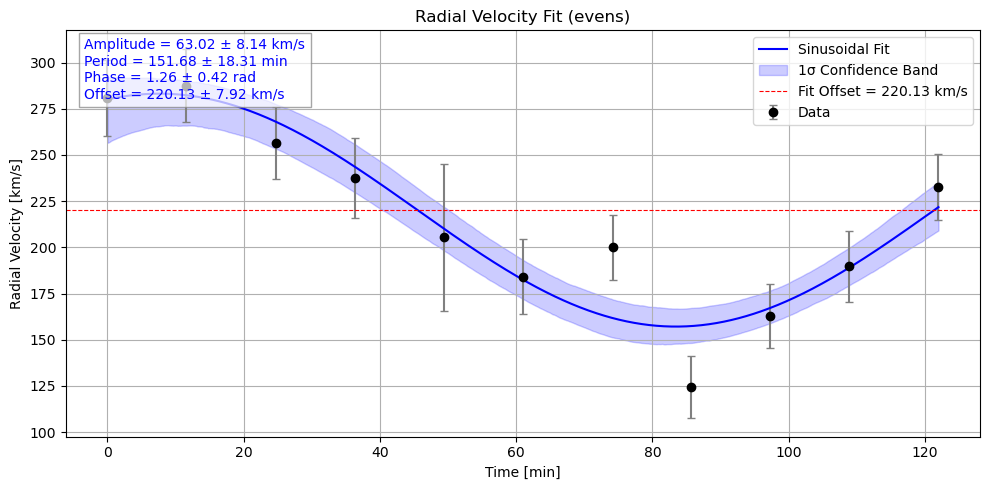

In [50]:
###FIT EVENS###
# --- Data extraction ---
v = fit_results_ds['radial_velocity'].values
v_err = fit_results_ds['radial_velocity_error'].values
time = fit_results_ds['time'].values

# Remove NaNs
# Remove NaNs
mask = ~np.isnan(v) & ~np.isnan(v_err) & ~np.isnan(time)
time = time[mask]
v = v[mask]
v_err = v_err[mask]

# Keep only even indices
time = time[::2]
v = v[::2]
v_err = v_err[::2]


# Convert time to minutes since first observation
time0 = time[0]
time = (time - time0) / np.timedelta64(1, 'm')  # now in minutes

# Define sinusoid model: v(t) = A * sin(2π f t + phi) + C
def sinusoid(t, A, f, phi, C):
    return A * np.sin(2 * np.pi * f * t + phi) + C

# Initial guess
A_guess = (np.nanmax(v) - np.nanmin(v)) / 2
f_guess = 1 / (time.max() - time.min())  # one full cycle
phi_guess = 0
C_guess = np.mean(v)

p0 = [A_guess, f_guess, phi_guess, C_guess]

# Fit to raw velocities
popt, pcov = curve_fit(sinusoid, time, v, sigma=v_err, absolute_sigma=True, p0=p0)
A_fit, f_fit, phi_fit, C_fit = popt
perr = np.sqrt(np.diag(pcov))
A_err, f_err, phi_err, C_err = perr

# Compute best-fit curve
time_fit = np.linspace(time.min(), time.max(), 1000)
v_fit = sinusoid(time_fit, *popt)

# Monte Carlo uncertainty band
n_samples = 1000
samples = np.random.multivariate_normal(popt, pcov, size=n_samples)
v_samples = np.array([sinusoid(time_fit, *s) for s in samples])
v_lower = np.percentile(v_samples, 16, axis=0)
v_upper = np.percentile(v_samples, 84, axis=0)

# Plot
plt.figure(figsize=(10, 5))
plt.errorbar(time, v, yerr=v_err, fmt='o', color='black', ecolor='gray', capsize=3, label='Data')
plt.plot(time_fit, v_fit, color='blue', label='Sinusoidal Fit')
plt.fill_between(time_fit, v_lower, v_upper, color='blue', alpha=0.2, label='1σ Confidence Band')
plt.title("Radial Velocity Fit (evens)")
plt.xlabel("Time [min]")
plt.ylabel("Radial Velocity [km/s]")
plt.axhline(C_fit, color='red', linestyle='--', linewidth=0.8, label=f'Fit Offset = {C_fit:.2f} km/s')
plt.legend()
plt.grid(True)

# Add fit parameters to plot
fit_label = (
    f"Amplitude = {A_fit:.2f} ± {A_err:.2f} km/s\n"
    f"Period = {1/f_fit:.2f} ± {(f_err / f_fit**2):.2f} min\n"
    f"Phase = {phi_fit:.2f} ± {phi_err:.2f} rad\n"
    f"Offset = {C_fit:.2f} ± {C_err:.2f} km/s"
)
plt.text(0.02, 0.98, fit_label, transform=plt.gca().transAxes,
         fontsize=10, verticalalignment='top', color='blue',
         bbox=dict(facecolor='white', alpha=0.7, edgecolor='gray'))

plt.tight_layout()
plt.show()

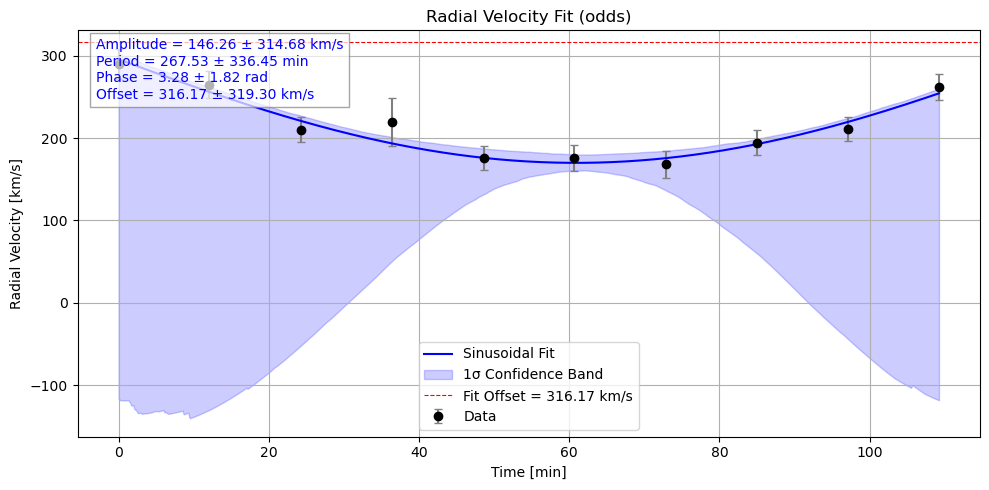

In [51]:
###FIT ODDS###
# --- Data extraction ---
v = fit_results_ds['radial_velocity'].values
v_err = fit_results_ds['radial_velocity_error'].values
time = fit_results_ds['time'].values

# Remove NaNs
# Remove NaNs
mask = ~np.isnan(v) & ~np.isnan(v_err) & ~np.isnan(time)
time = time[mask]
v = v[mask]
v_err = v_err[mask]

# Keep only even indices
time = time[1::2]
v = v[1::2]
v_err = v_err[1::2]


# Convert time to minutes since first observation
time0 = time[0]
time = (time - time0) / np.timedelta64(1, 'm')  # now in minutes

# Define sinusoid model: v(t) = A * sin(2π f t + phi) + C
def sinusoid(t, A, f, phi, C):
    return A * np.sin(2 * np.pi * f * t + phi) + C

# Initial guess
A_guess = (np.nanmax(v) - np.nanmin(v)) / 2
f_guess = 1 / (time.max() - time.min())  # one full cycle
phi_guess = 0
C_guess = np.mean(v)

p0 = [A_guess, f_guess, phi_guess, C_guess]

# Fit to raw velocities
popt, pcov = curve_fit(sinusoid, time, v, sigma=v_err, absolute_sigma=True, p0=p0)
A_fit, f_fit, phi_fit, C_fit = popt
perr = np.sqrt(np.diag(pcov))
A_err, f_err, phi_err, C_err = perr

# Compute best-fit curve
time_fit = np.linspace(time.min(), time.max(), 1000)
v_fit = sinusoid(time_fit, *popt)

# Monte Carlo uncertainty band
n_samples = 1000
samples = np.random.multivariate_normal(popt, pcov, size=n_samples)
v_samples = np.array([sinusoid(time_fit, *s) for s in samples])
v_lower = np.percentile(v_samples, 16, axis=0)
v_upper = np.percentile(v_samples, 84, axis=0)

# Plot
plt.figure(figsize=(10, 5))
plt.errorbar(time, v, yerr=v_err, fmt='o', color='black', ecolor='gray', capsize=3, label='Data')
plt.plot(time_fit, v_fit, color='blue', label='Sinusoidal Fit')
plt.fill_between(time_fit, v_lower, v_upper, color='blue', alpha=0.2, label='1σ Confidence Band')
plt.title("Radial Velocity Fit (odds)")
plt.xlabel("Time [min]")
plt.ylabel("Radial Velocity [km/s]")
plt.axhline(C_fit, color='red', linestyle='--', linewidth=0.8, label=f'Fit Offset = {C_fit:.2f} km/s')
plt.legend()
plt.grid(True)

# Add fit parameters to plot
fit_label = (
    f"Amplitude = {A_fit:.2f} ± {A_err:.2f} km/s\n"
    f"Period = {1/f_fit:.2f} ± {(f_err / f_fit**2):.2f} min\n"
    f"Phase = {phi_fit:.2f} ± {phi_err:.2f} rad\n"
    f"Offset = {C_fit:.2f} ± {C_err:.2f} km/s"
)
plt.text(0.02, 0.98, fit_label, transform=plt.gca().transAxes,
         fontsize=10, verticalalignment='top', color='blue',
         bbox=dict(facecolor='white', alpha=0.7, edgecolor='gray'))

plt.tight_layout()
plt.show()

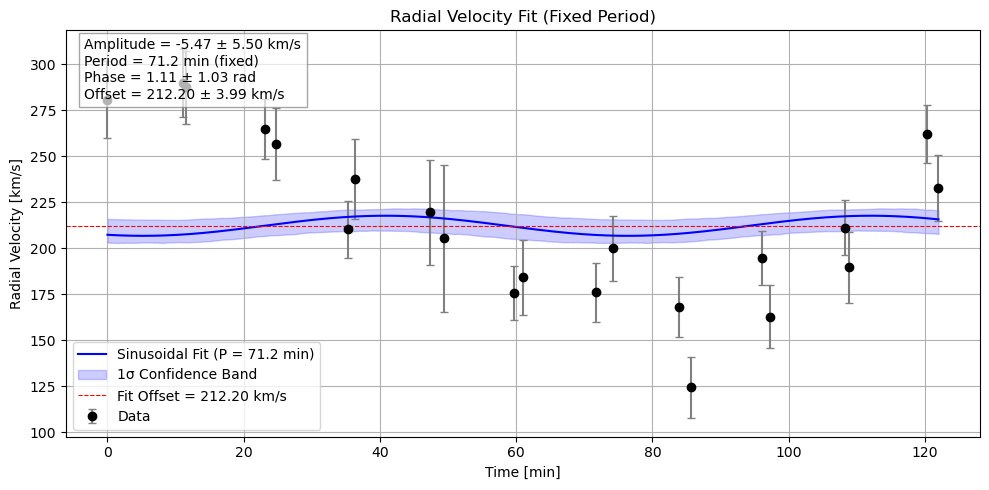

Amplitude = -5.47 ± 5.50 km/s
Phase = 1.110 ± 1.031 rad
Offset = 212.20 ± 3.99 km/s
Period = 71.2 min (fixed)


In [52]:
#FIXED ORBITAL PERIOD
v = fit_results_ds['radial_velocity'].values
v_err = fit_results_ds['radial_velocity_error'].values
time = fit_results_ds['time'].values

# Remove NaNs
mask = ~np.isnan(v) & ~np.isnan(v_err) & ~np.isnan(time)
v = v[mask]
v_err = v_err[mask]
time = time[mask]

# Convert time to minutes since first observation
time0 = time[0]
time = (time - time0) / np.timedelta64(1, 'm')

#Fixed period (known)
P_known = 71.2          # minutes
f_known = 1.0 / P_known  # cycles per minute

#Sinusoid with fixed frequency
def sinusoid_fixedP(t, A, phi, C):
    return A * np.sin(2 * np.pi * f_known * t + phi) + C

A_guess = 0.5 * (np.nanmax(v) - np.nanmin(v))
phi_guess = 0.0
C_guess = np.nanmean(v)
p0 = [A_guess, phi_guess, C_guess]

popt, pcov = curve_fit(
    sinusoid_fixedP,
    time,
    v,
    sigma=v_err,
    absolute_sigma=True,
    p0=p0,
)

A_fit, phi_fit, C_fit = popt
A_err, phi_err, C_err = np.sqrt(np.diag(pcov))

time_fit = np.linspace(time.min(), time.max(), 1000)
v_fit = sinusoid_fixedP(time_fit, *popt)

n_samples = 1000
samples = np.random.multivariate_normal(popt, pcov, size=n_samples)
v_samples = np.array([
    sinusoid_fixedP(time_fit, *s) for s in samples
])

v_lower = np.percentile(v_samples, 16, axis=0)
v_upper = np.percentile(v_samples, 84, axis=0)

plt.figure(figsize=(10, 5))
plt.errorbar(
    time, v, yerr=v_err,
    fmt='o', color='black', ecolor='gray',
    capsize=3, label='Data'
)
plt.plot(time_fit, v_fit, color='blue', label='Sinusoidal Fit (P = 71.2 min)')
plt.fill_between(
    time_fit, v_lower, v_upper,
    color='blue', alpha=0.2, label='1σ Confidence Band'
)
plt.axhline(
    C_fit, color='red', linestyle='--', linewidth=0.8,
    label=f'Fit Offset = {C_fit:.2f} km/s'
)

plt.title("Radial Velocity Fit (Fixed Period)")
plt.xlabel("Time [min]")
plt.ylabel("Radial Velocity [km/s]")
plt.legend()
plt.grid(True)

fit_label = (
    f"Amplitude = {A_fit:.2f} ± {A_err:.2f} km/s\n"
    f"Period = {P_known:.1f} min (fixed)\n"
    f"Phase = {phi_fit:.2f} ± {phi_err:.2f} rad\n"
    f"Offset = {C_fit:.2f} ± {C_err:.2f} km/s"
)

plt.text(
    0.02, 0.98, fit_label,
    transform=plt.gca().transAxes,
    fontsize=10, verticalalignment='top',
    bbox=dict(facecolor='white', alpha=0.7, edgecolor='gray')
)

plt.tight_layout()
plt.show()

print(f"Amplitude = {A_fit:.2f} ± {A_err:.2f} km/s")
print(f"Phase = {phi_fit:.3f} ± {phi_err:.3f} rad")
print(f"Offset = {C_fit:.2f} ± {C_err:.2f} km/s")
print(f"Period = {P_known:.1f} min (fixed)")


In [ ]:
# Define your input files
files = {
    'Halpha': 'rv_Halpha.nc',
    'Hbeta': 'rv_Hbeta.nc',
    'Hgamma': 'rv_Hgamma.nc',
    'Hdelta': 'rv_Hdelta.nc'
}

datasets = []

# Open the first file to use its 'time' as the master reference
ref_line, ref_file = next(iter(files.items()))
ref_ds = xr.open_dataset(ref_file)
time = ref_ds['time']
ref_ds = ref_ds.assign_coords(time=time)  # explicitly fix coordinate
ref_ds = ref_ds.expand_dims(line=[ref_line])
datasets.append(ref_ds)

# Now load the rest, reassigning 'time' from reference
for line, fname in list(files.items())[1:]:
    ds = xr.open_dataset(fname)
    ds = ds.assign_coords(time=time)  # force time alignment
    ds = ds.expand_dims(line=[line])
    datasets.append(ds)

# Combine along 'line' dimension
combined_ds = xr.concat(datasets, dim='line')

# Save to file
combined_ds.to_netcdf("combined_H_lines_rv.nc")



In [ ]:
print(combined_ds)